In [ ]:
import argparse
import seaborn as sns
import logging
from pathlib import Path
from typing import Literal, Optional

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import (
    calculate_weights,
    get_available_trackers,
    load_trackers,
    get_rebalance_dates,
    cap_long_only_weights,
    calc_covariance,
    cov_to_vols,
)
from backtest import backtest2
from entities import FX_TRACKER_DICT, EM_CDS_TRACKER_DICT

from bwlogger import StyleAdapter, basic_setup
from bwutils import open_file
from portfolio.construction import calculate_weights as calculate_weights_fh

# testing

# Plot

In [190]:
dict_groups = {
    "Long Only": ["L-CDS-EW", "L-CDS-IV", "L-FX-EW", "L-FX-IV", "L-EW", "L-IV"],
    "Long Short Ativo": [
        "L-CDS-S-FX-EW",
        "L-CDS-S-FX-IV-BN",
        "L-CDS-S-FX-IV",
        "L-FX-S-CDS-EW",
        "L-FX-S-CDS-IV-BN",
        "L-FX-S-CDS-IV",
    ],
    "Long Short Pares": [
        "LS-CDS_FX-BN-BRL",
        "LS-CDS_FX-IV-BRL",
        "LS-CDS_FX-BN-CLP",
        "LS-CDS_FX-IV-CLP",
        "LS-CDS_FX-BN-CNY",
        "LS-CDS_FX-IV-CNY",
        "LS-CDS_FX-BN-COP",
        "LS-CDS_FX-IV-COP",
        "LS-CDS_FX-BN-IDR",
        "LS-CDS_FX-IV-IDR",
        "LS-CDS_FX-BN-MXN",
        "LS-CDS_FX-IV-MXN",
        "LS-CDS_FX-BN-RUB",
        "LS-CDS_FX-IV-RUB",
        "LS-CDS_FX-BN-TRY",
        "LS-CDS_FX-IV-TRY",
        "LS-CDS_FX-BN-ZAR",
        "LS-CDS_FX-IV-ZAR",
    ],
    "Long Short Classe": [
        "LS-CDS-FX-BN-IV",
        "LS-CDS-FX-IV",
        "LS-FX-CDS-BN-IV",
        "LS-FX-CDS-IV",
    ],
    "Timeseries Momentum (FX)": [
        "TSMOM-FX-12",
        "TSMOM-FX-6",
        "TSMOM-FX-3",
        "TSMOM-FX-1",
    ],
    "Timeseries Momentum (CDS)": [
        "TSMOM-CDS-12",
        "TSMOM-CDS-6",
        "TSMOM-CDS-3",
        "TSMOM-CDS-1",
    ],
    "Timeseries Momentum (CDS + FX)": [
        "TSMOM-12",
        "TSMOM-6",
        "TSMOM-3",
        "TSMOM-1",
    ],
    "Timeseries Momentum (1M)": [
        "TSMOM-1",
        "TSMOM-FX-1",
        "TSMOM-CDS-1",
    ],
    "Valor": [
        "VALUE-CDS-PAIRED",
        "VALUE-FX-PAIRED",
    ],
    "Cross-Sectional Momentum (FX)": [
        "XSMOM-FX-12",
        "XSMOM-FX-6",
        "XSMOM-FX-3",
        "XSMOM-FX-1",
    ],
    "Cross-Sectional Momentum (CDS)": [
        "XSMOM-CDS-12",
        "XSMOM-CDS-6",
        "XSMOM-CDS-3",
        "XSMOM-CDS-1",
    ],
    "Cross-Sectional Momentum (CDS + FX)": [
        "XSMOM-12",
        "XSMOM-6",
        "XSMOM-3",
        "XSMOM-1",
    ],
    "Cross-Sectional Momentum (1M)": [
        "XSMOM-1",
        "XSMOM-FX-1",
        "XSMOM-CDS-1",
    ],
    "XSMOM vs TSMOM (FX)": [
        "XSMOM-FX-1",
        "TSMOM-FX-1",
    ],
    "XSMOM vs TSMOM (CDS)": [
        "XSMOM-CDS-1",
        "TSMOM-CDS-1",
    ],
}

In [51]:
def calculate_rolling_sharpe_ratio(log_returns):
    numerator = log_returns.rolling(window=252).sum()
    denominator = log_returns.rolling(window=252).std() * (252 ** (0.5))
    return (numerator / denominator).rolling(window=252).mean()


def calculate_drawdown(log_returns_acc):
    acc_returns = np.exp(log_returns_acc)
    return acc_returns / acc_returns.expanding().max() - 1

In [ ]:
FOLDER = Path(
    "C:/Users/pcampos/OneDrive - Insper - Instituto de Ensino e Pesquisa/Dissertação Mestrado/Analysis/backtests"
)


list_series = []


for file_path in FOLDER.glob("*.xlsx"):


    s_backtest = pd.read_excel(file_path, index_col=0)["backtest"]


    s_backtest.name = file_path.stem

    list_series.append(s_backtest)


df_backtest = pd.concat(list_series, axis=1).sort_index(ascending=True)
df_backtest

In [ ]:
end_of_months = (
    df_backtest.index.to_series()
    .groupby(df_backtest.index.to_period("M"))
    .max()[:-1]
    .to_list()
)
monthly_log_returns = np.log(df_backtest.loc[end_of_months]).diff(1)

In [ ]:
OUTPUT_FOLDER = Path(
    r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Dissertação Mestrado\Analysis"
)
data = np.log(df_backtest.dropna(how="all")).diff(1).cumsum()


def plot_trackers_returns(
    data, title, columns, palette="tab10", figsize=(5, 3), y_label="Log-Retorno"
):
    plt.rcParams["font.family"] = "Calibri"
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=figsize)
    sns.lineplot(data=data[columns], palette=palette, linewidth=1, dashes=False)
    plt.legend(loc="center right", bbox_to_anchor=(0, 0.5), fontsize=8, frameon=False)
    plt.gca().yaxis.set_ticks_position("right")
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"  {y:.00%}"))
    plt.grid(True, linestyle="--", linewidth=0.7)
    plt.xlabel(None)
    plt.ylabel(y_label, fontsize=8)
    plt.gca().yaxis.set_label_position("right")
    plt.xlim(data.dropna(how="all").index.min(), data.dropna(how="all").index.max())
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tick_params("both", length=0)
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_overleaf/{title}_acc_return.pdf"),
        bbox_inches="tight",
    )
    # plt.gcf().set_size_inches(10, 6)

    plt.title(title, fontsize=10, fontweight="bold")
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_powerpoint/{title}_acc_return.svg"),
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()


def plot_trackers_returns_boxplot(
    data,
    title,
    columns,
    palette="tab10",
    y_label="Log-Retorno",
    width_per_category=0.5,
    base_width=5,
):
    plt.rcParams["font.family"] = "Calibri"
    sns.set_theme(style="whitegrid")
    data = data[data.sum().sort_values().index[::-1]]
    num_categories = len(columns)
    figsize = (base_width, num_categories * width_per_category)
    plt.figure(figsize=figsize)
    data = data.reset_index()
    melted_data = data.melt(
        id_vars="date", var_name="Strategy", value_name="Log-Retorno"
    )
    sns.boxplot(x="Log-Retorno", y="Strategy", data=melted_data, palette=palette)
    plt.xlabel("Log-Retorno", fontsize=8)
    plt.ylabel(None)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True, linestyle="--", linewidth=0.7)
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_overleaf/{title}_returns.pdf"), bbox_inches="tight", format="pdf"
    )
    plt.gcf().set_size_inches(5, 3)
    plt.title(title, fontsize=10, fontweight="bold")
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_powerpoint/{title}_returns.svg"),
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()


def plot_trackers_returns_boxenplot(
    data,
    title,
    columns,
    palette="tab10",
    figsize=(5, 3),
    x_label="Log-Retorno",
    width_per_category=0.5,
    base_width=5,
):
    data = data[data.sum().sort_values().index[::-1]]
    num_categories = len(columns)
    figsize = (base_width, num_categories * width_per_category)
    plt.rcParams["font.family"] = "Calibri"
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=figsize)
    sns.boxenplot(
        data=data[columns].rename(columns=lambda col: col.rjust(22)),
        palette=palette,
        orient="h",
    )
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"  {y:.00%}"))
    plt.grid(True, linestyle="--", linewidth=0.7)
    plt.ylabel(None)
    plt.xlabel(x_label, fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8, fontweight="bold")
    plt.tick_params("both", length=0)
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_overleaf/{title}_boxplot.pdf"), bbox_inches="tight"
    )
    plt.gcf().set_size_inches(5, 3)

    plt.title(title, fontsize=10, fontweight="bold")
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_powerpoint/{title}_boxplot.svg"),
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()


def plot_rolling_sharpe_ratio(
    data, title, columns, palette="tab10", figsize=(5, 3), y_label="Sharpe Ratio (Média Movel 1 Ano)"
):
    plt.rcParams["font.family"] = "Calibri"
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=figsize)
    sns.lineplot(
        data=data[columns].rename(columns=lambda col: col.ljust(22)),
        palette=palette,
        linewidth=1,
        dashes=False,
    )
    plt.legend(loc="center right", bbox_to_anchor=(0, 0.5), fontsize=8, frameon=False)
    plt.gca().yaxis.set_ticks_position("right")
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"  {y:.1f}"))
    plt.grid(True, linestyle="--", linewidth=0.7)
    plt.xlabel(None)
    plt.ylabel(y_label, fontsize=8)
    plt.gca().yaxis.set_label_position("right")
    plt.xlim(data.dropna(how="all").index.min(), data.dropna(how="all").index.max())
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tick_params("both", length=0)
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_overleaf/{title}_rolling_sharpe.pdf"),
        bbox_inches="tight",
        transparent=True,
    )

    plt.gcf().set_size_inches(5, 3)

    plt.title("Média Móvel (1 ano) Sharpe Ratio", fontsize=10, fontweight="bold")
    plt.ylabel(None)
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_powerpoint/{title}_rolling_sharpe.svg"),
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()


def plot_drawdowns(
    data, title, columns, palette="tab10", figsize=(5, 3), y_label="Drawdown"
):
    plt.rcParams["font.family"] = "Calibri"
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=figsize)
    sns.lineplot(
        data=data[columns].rename(columns=lambda col: col.ljust(22)),
        palette=palette,
        linewidth=1,
        dashes=False,
    )
    plt.legend(loc="center right", bbox_to_anchor=(0, 0.5), fontsize=8, frameon=False)
    plt.gca().yaxis.set_ticks_position("right")
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"  {y:.0%}"))
    plt.grid(True, linestyle="--", linewidth=0.7)
    plt.xlabel(None)
    plt.ylabel(y_label, fontsize=8)
    plt.gca().yaxis.set_label_position("right")
    plt.xlim(data.dropna(how="all").index.min(), data.dropna(how="all").index.max())
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tick_params("both", length=0)
    plt.ylim(None, 0)
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_overleaf/{title}_drawdown.pdf"),
        bbox_inches="tight",
        transparent=True,
    )
    plt.gcf().set_size_inches(5, 3)

    plt.title("Drawdown", fontsize=10, fontweight="bold")
    plt.ylabel(None)
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_powerpoint/{title}_drawdown.svg"),
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

In [ ]:
from run_backtest import trackers

_df = (
    np.exp(
        np.log(
            trackers.filter(like="fx")
            .rename(lambda col: col[:3], axis=1)
            .dropna(how="all")
        )
        .diff(1)
        .cumsum()
    )
    - 1
)
# _df = (trackers / trackers.apply(lambda col: col.dropna().iloc[0])).filter(like="fx")
plot_trackers_returns(
    _df,
    "FX Trackers",
    _df.columns,
    palette="tab20",
    figsize=(10, 6),
    y_label="Retorno",
)


_df = (
    np.exp(
        np.log(
            trackers.filter(like="cds")
            .rename(lambda col: col[:3], axis=1)
            .dropna(how="all")
        )
        .diff(1)
        .cumsum()
    )
    - 1
)
# _df = (trackers / trackers.apply(lambda col: col.dropna().iloc[0])).filter(like="cds")
plot_trackers_returns(
    _df,
    "CDS Trackers",
    _df.columns,
    palette="tab20",
    figsize=(10, 6),
    y_label="Retorno",
)

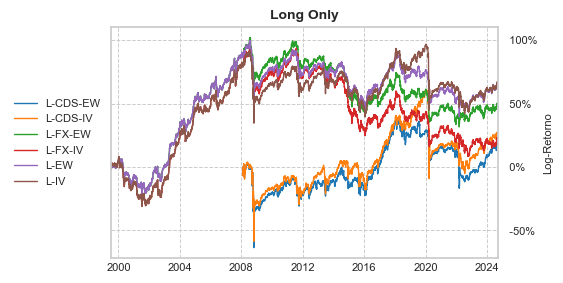

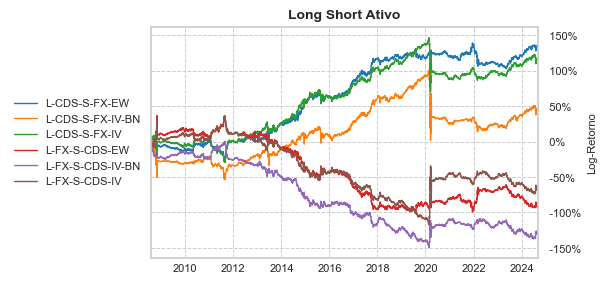

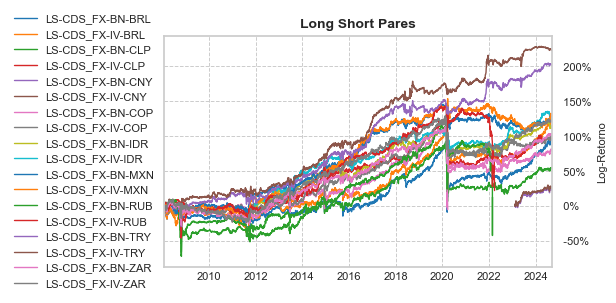

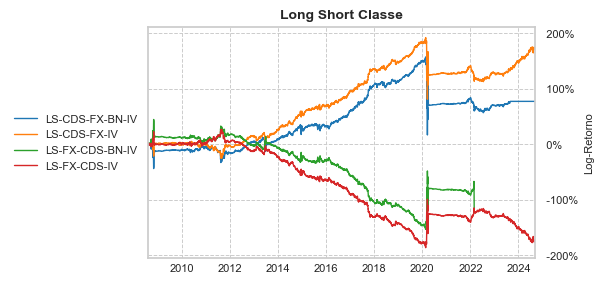

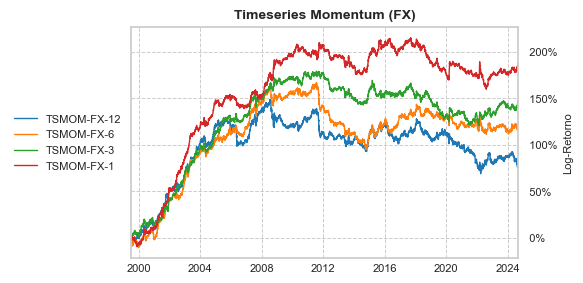

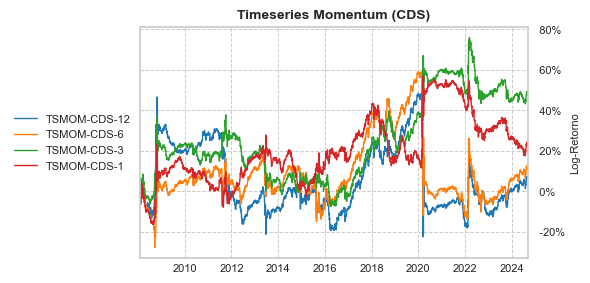

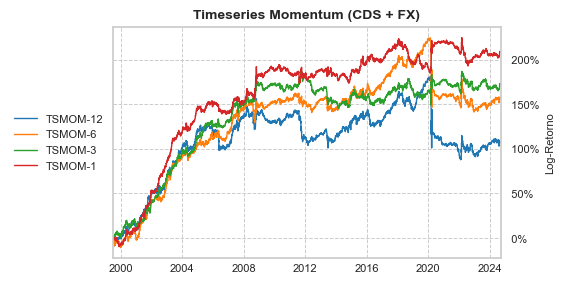

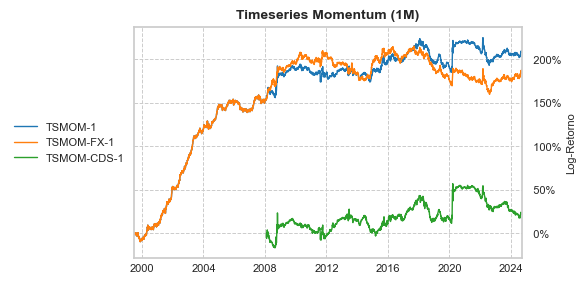

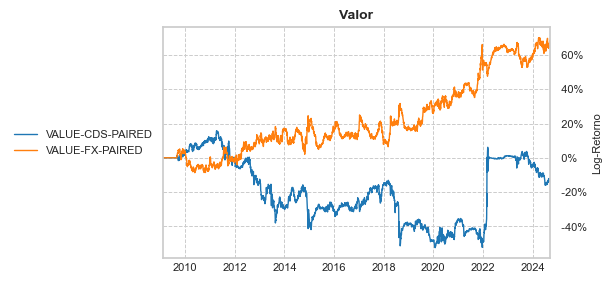

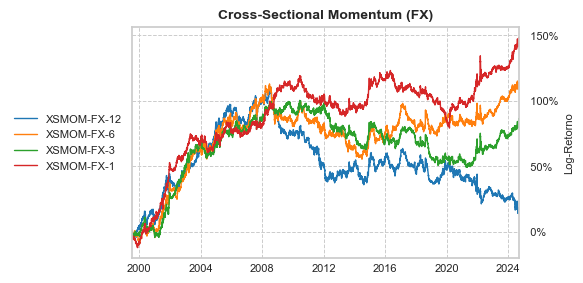

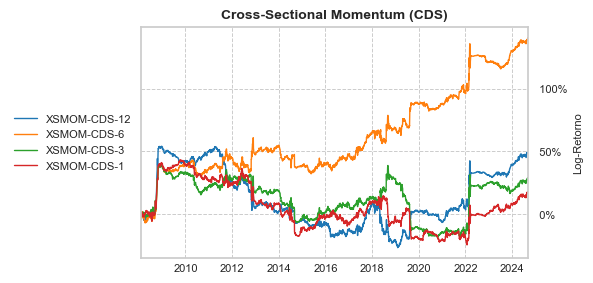

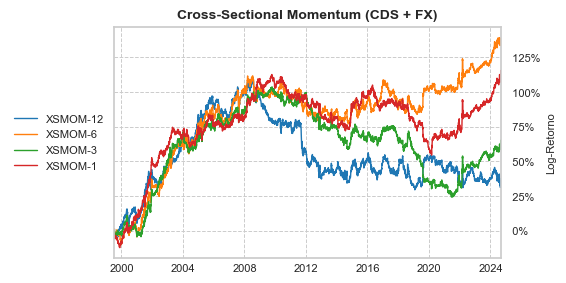

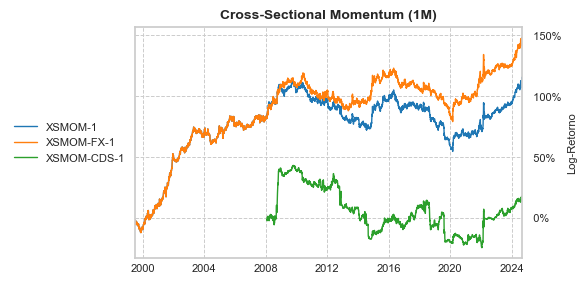

In [194]:
for group, columns in dict_groups.items():
    plot_trackers_returns(data[columns], group, columns)

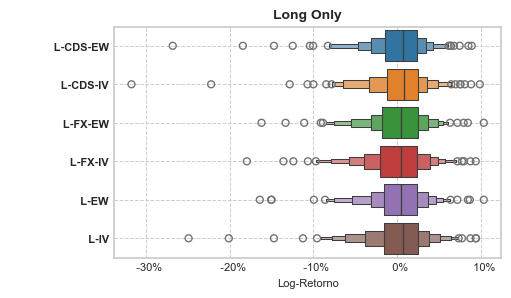

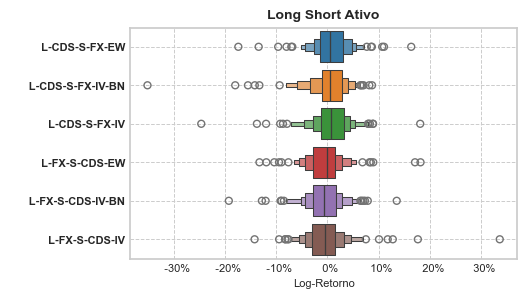

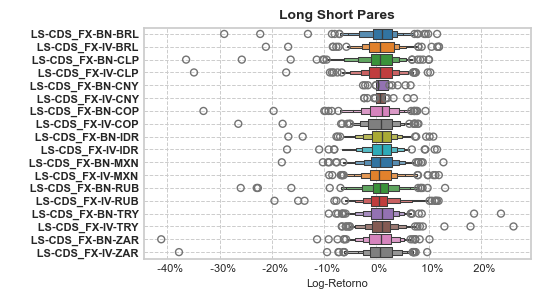

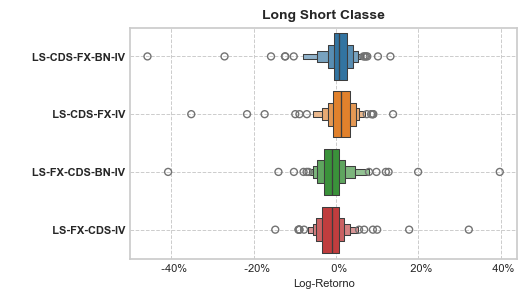

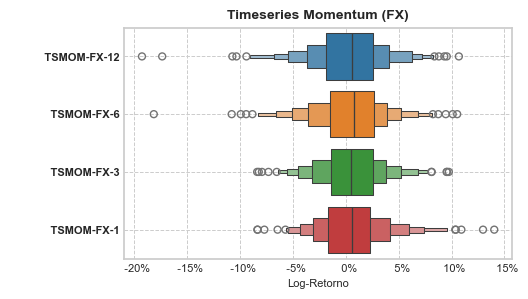

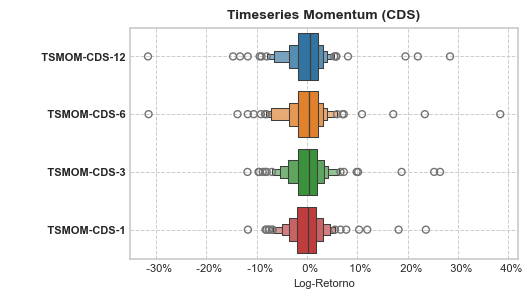

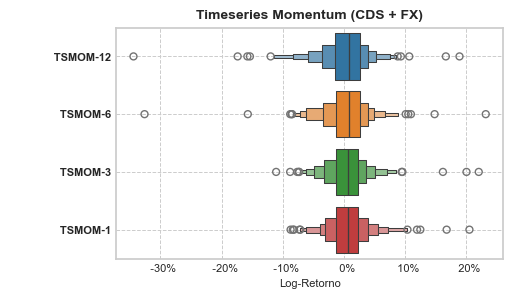

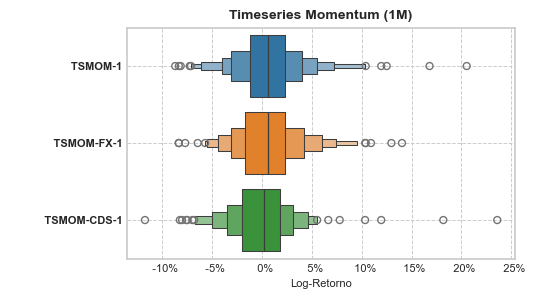

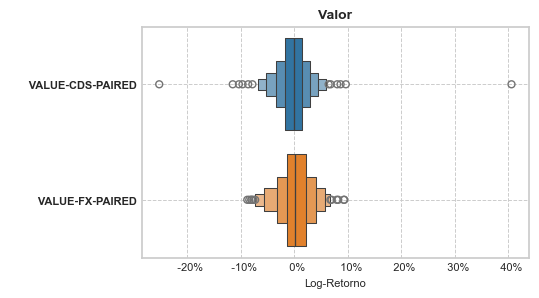

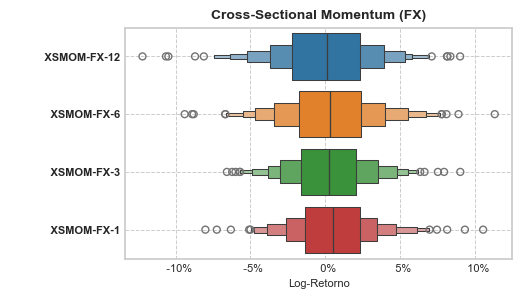

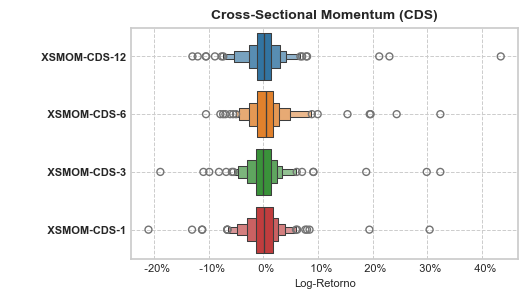

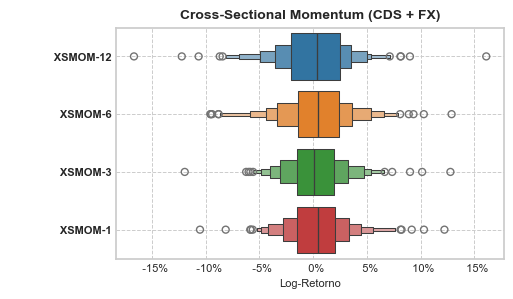

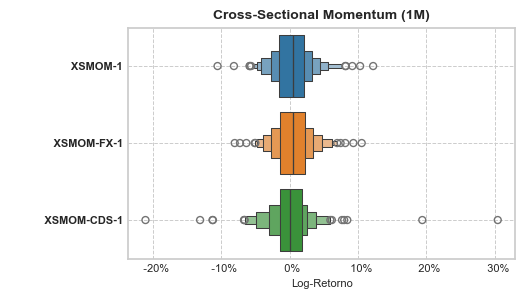

In [193]:


for group, columns in dict_groups.items():
    plot_trackers_returns_boxenplot(monthly_log_returns[columns], group, columns)

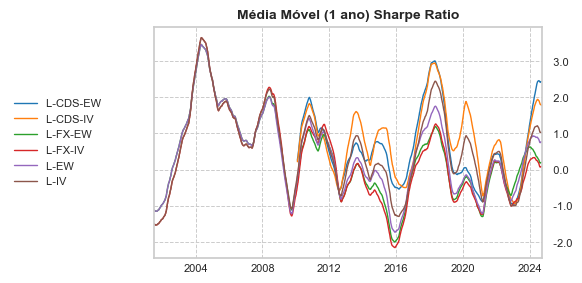

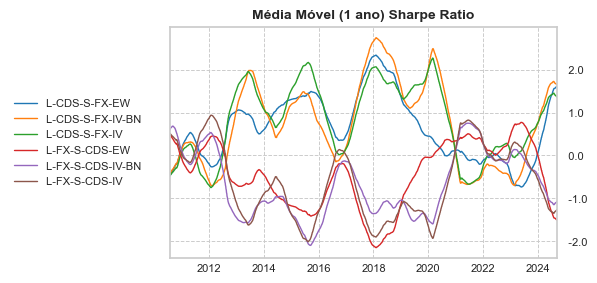

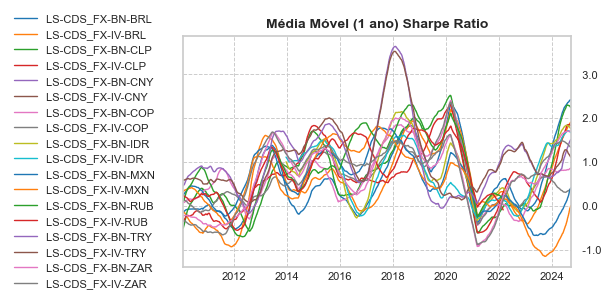

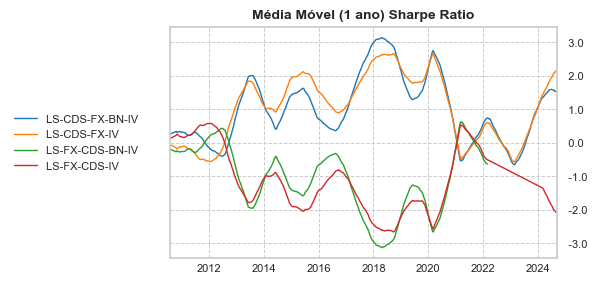

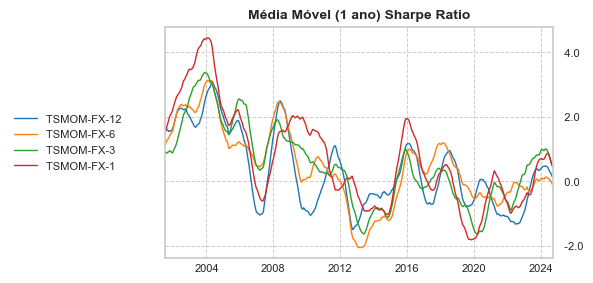

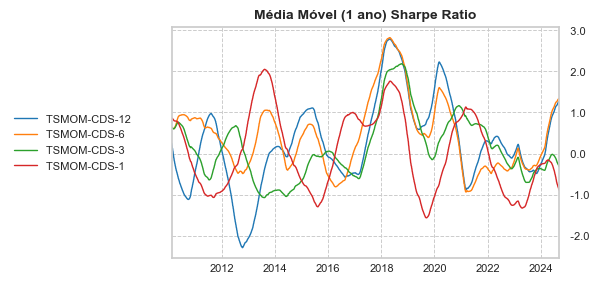

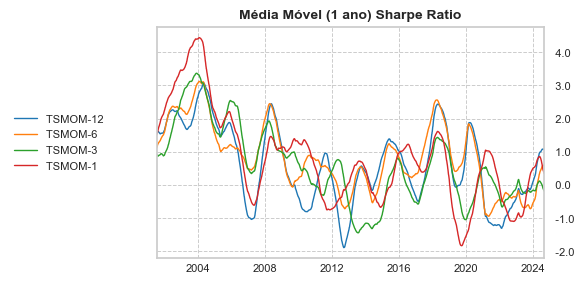

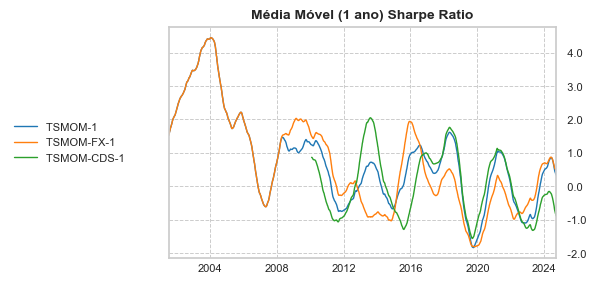

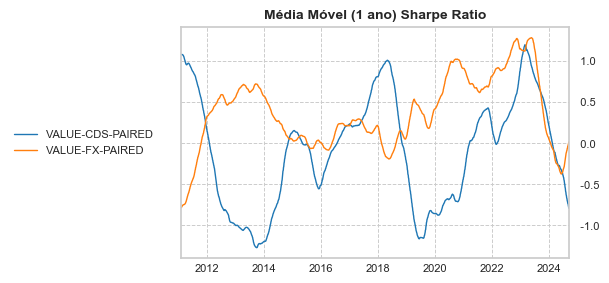

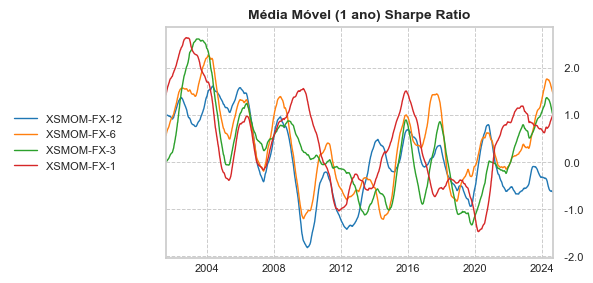

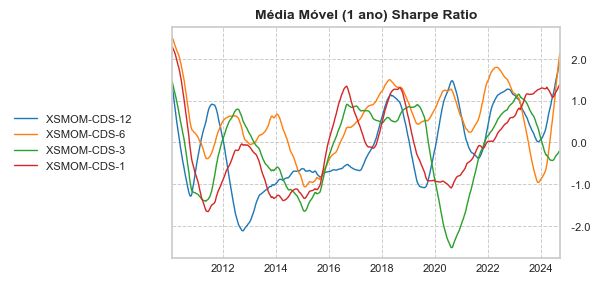

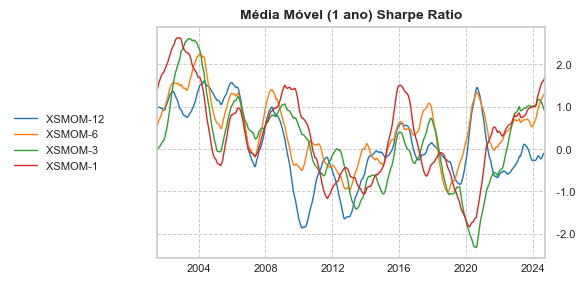

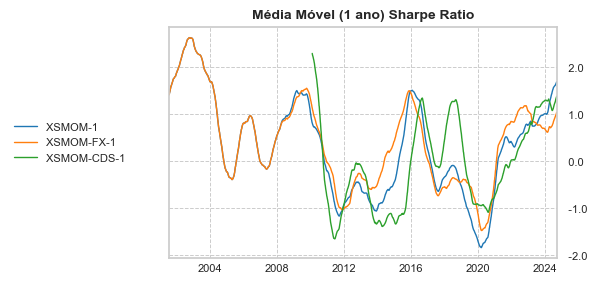

In [192]:
for group, columns in dict_groups.items():
    plot_rolling_sharpe_ratio(
        calculate_rolling_sharpe_ratio(data[columns].diff(1)), group, columns
    )

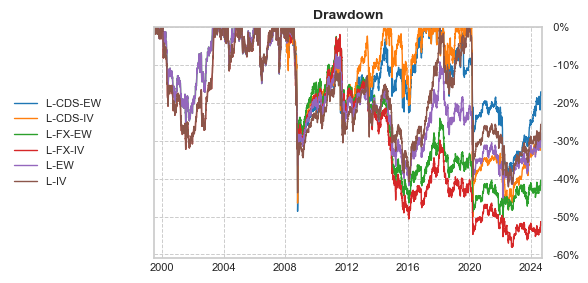

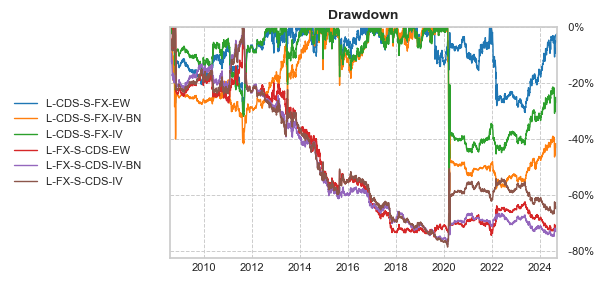

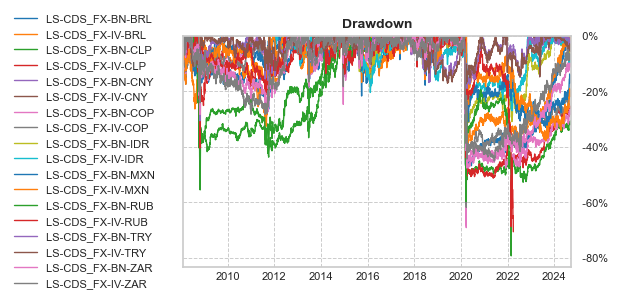

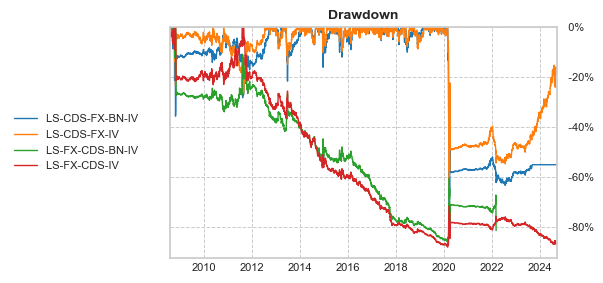

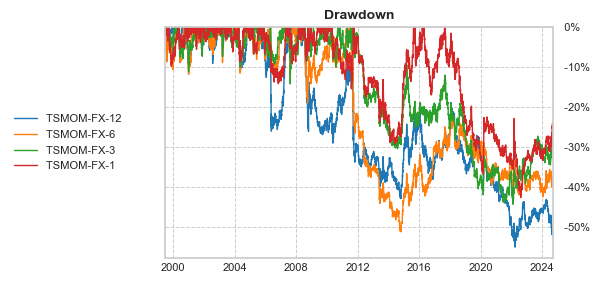

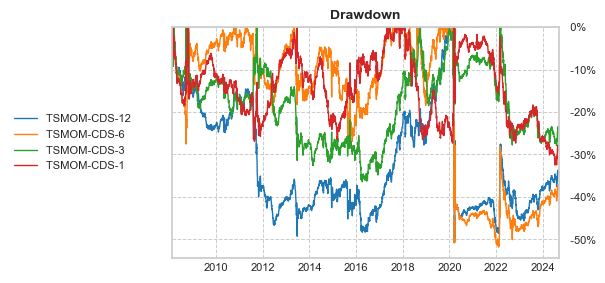

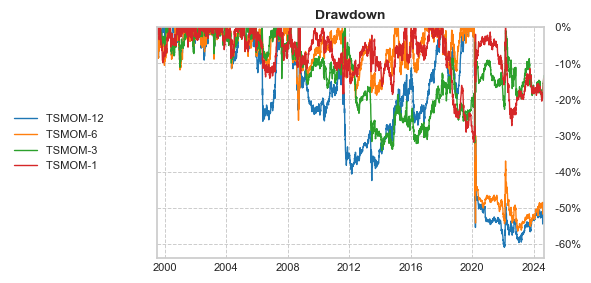

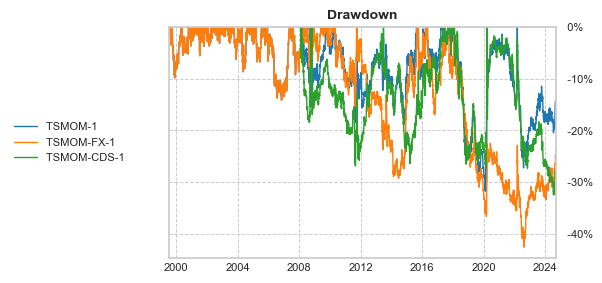

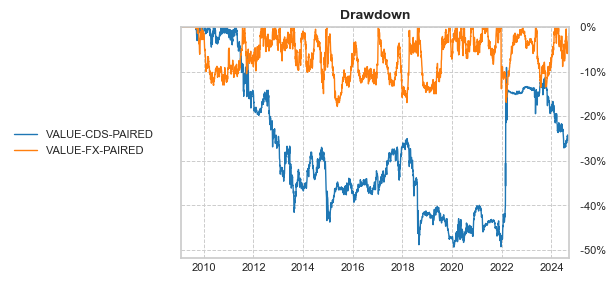

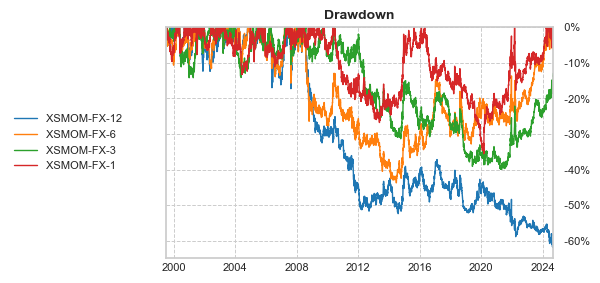

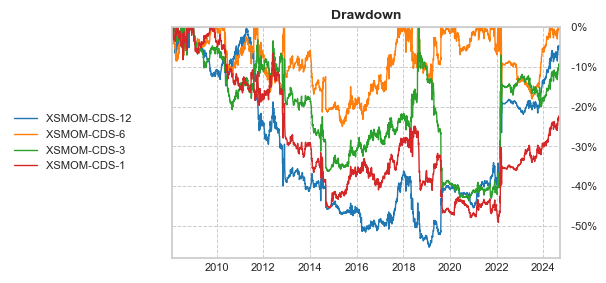

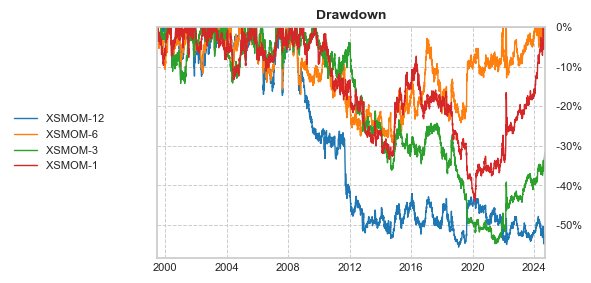

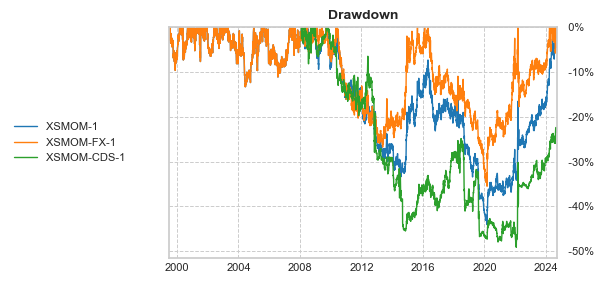

In [191]:
for group, columns in dict_groups.items():
    plot_drawdowns(calculate_drawdown(data[columns]), group, columns)